# Analysis of NIST Ground dataset

This notebook uses PVPRO to analyze the NIST dataset.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import json
import sys
import ipywidgets as widgets
import matplotlib
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sys import path
from solardatatools import DataHandler
from glob import glob
from pickle import load, dump
from datetime import datetime
from pvlib.pvsystem import retrieve_sam
from pvanalytics.features import clipping
from ipywidgets import interact, interact_manual
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting

from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.plotting import PvProPlot

## Load data

Load dataframe and info files.

In [2]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/752151f8-7ba3-486e-954c-0126227f89b5/resource/e40a91f9-fa84-4a2b-b6d8-312c15fc761b/download/nist01_onemin-ground.pkl
sys_name = 'NIST_ground'
dfi = pd.read_pickle('examples/data/nist01_onemin-Ground.pkl')
df = dfi[::20]

In [3]:
df['InvIDCin_Avg'][df['RefCell1_Wm2_Avg']>1000]

TIMESTAMP
2015-02-18 12:00:00     44.49
2015-02-19 11:20:00    279.10
2015-02-23 12:00:00    769.40
2015-02-27 11:20:00    747.90
2015-02-27 12:00:00    739.40
                        ...  
2018-10-12 11:46:00    740.80
2018-10-12 12:06:00    754.00
2018-10-13 11:26:00    770.20
2018-10-13 13:06:00    760.20
2018-11-17 11:50:00    727.40
Name: InvIDCin_Avg, Length: 2066, dtype: float64

Input Metadata

In [4]:
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6
delta_T = 3
technology = 'mono-Si'

Get module from CEC database. Or can enter parameters manually. Only need a dictionary with 'alpha_sc' (units of A/C), 'R_sh_ref' and 'N_s'.

In [5]:
cec = retrieve_sam('CECmod')
module = cec['Sharp_NU_U235F2']
print(module)
module['alpha_sc'] = alpha_isc

Technology            Mono-c-Si
Bifacial                      0
STC                       235.2
PTC                       211.9
A_c                       1.573
Length                    1.618
Width                     0.972
N_s                          60
I_sc_ref                    8.6
V_oc_ref                   37.0
I_mp_ref                   7.84
V_mp_ref                   30.0
alpha_sc               0.003784
beta_oc                -0.12173
T_NOCT                     45.4
a_ref                  1.572369
I_L_ref                8.628778
I_o_ref                     0.0
R_s                    0.300444
R_sh_ref              89.785065
Adjust                14.428038
gamma_r                  -0.458
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Sharp_NU_U235F2, dtype: object


## Initiate PVPRO

Load plotting 

In [6]:
pvproplot = PvProPlot(system_name='Synthetic dataset')

Instantiate PVPRO data handler.

In [7]:
pre = Preprocessor(df,
                   voltage_dc_key = voltage_dc_key,
                   current_dc_key = current_dc_key,
                   temperature_module_key = temperature_module_key,
                   irradiance_poa_key = irradiance_poa_key,
                   modules_per_string = modules_per_string,
                   parallel_strings = parallel_strings,
                   techonology = technology,
                   alpha_isc = alpha_isc,
                   cells_in_series = cells_in_series
                   )

In [8]:
pre.calculate_cell_temperature(delta_T=3)

Cell temperature assigned to 'temperature_cell'


In [9]:
method='sdt'
if method=='sdt':
    pre.run_preprocess_sdt(correct_dst=True)
    pre.classify_points_sdt()
    pre.build_operating_cls()

elif method=='fast':
    pre.classify_points_pva()
    pre.build_operating_cls()


Fixing daylight savings time shift...
Running solar data tools...


/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/solardatatools/time_axis_manipulation.py:205: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  delta, count = mode(diff[fltr])
/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/solardatatools/data_quality.py:60: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

total time: 4.54 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              0.81s
Cleaning                   2.23s
Filtering/Summarizing      1.50s
    Data quality           0.09s
    Clear day detect       0.10s
    Clipping detect        0.86s
    Capacity change detect 0.45s
Extra Column Processing    0.00s


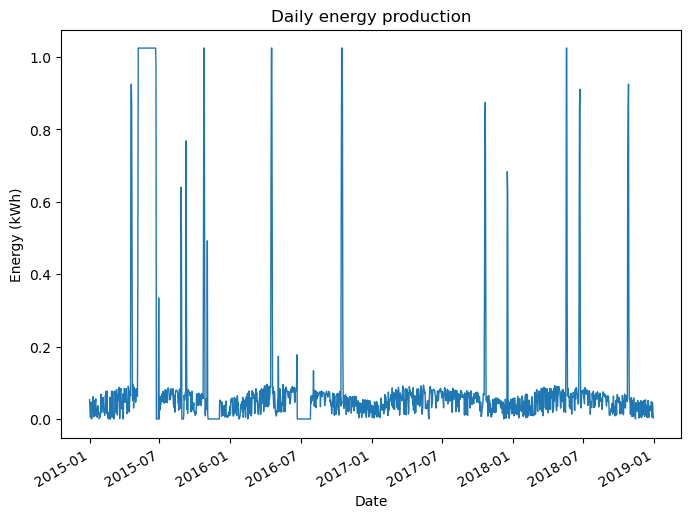

In [10]:
fig = pre.dh.plot_daily_energy()

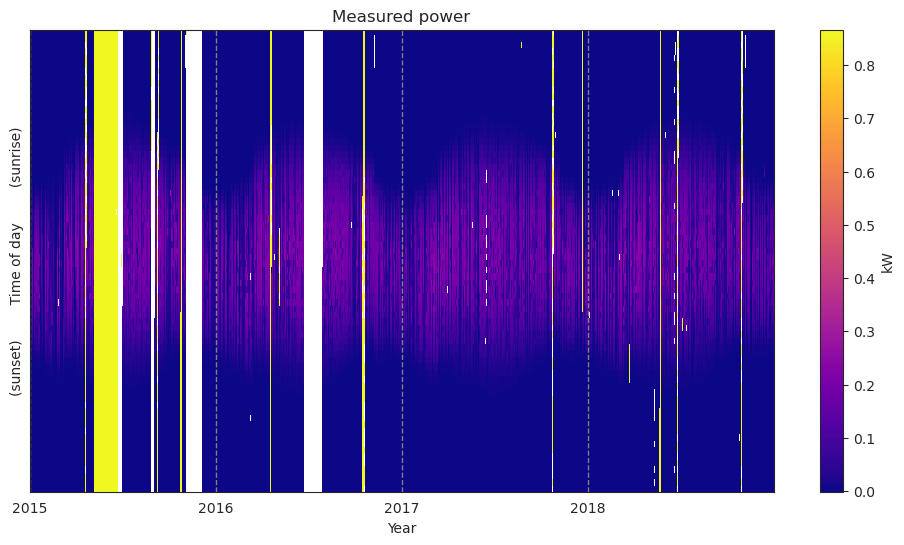

In [11]:
if method=='sdt':
    fig = pre.dh.plot_heatmap()

/Users/baojie/Library/CloudStorage/OneDrive-stu.xjtu.edu.cn/LBL_study/Git_PVPRO/pvpro_master/pvpro/pvpro/plotting.py:667: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['','Anomaly','Inverter off','MPP', 'Open circuit', 'Clipped'])


<Figure size 1200x600 with 0 Axes>

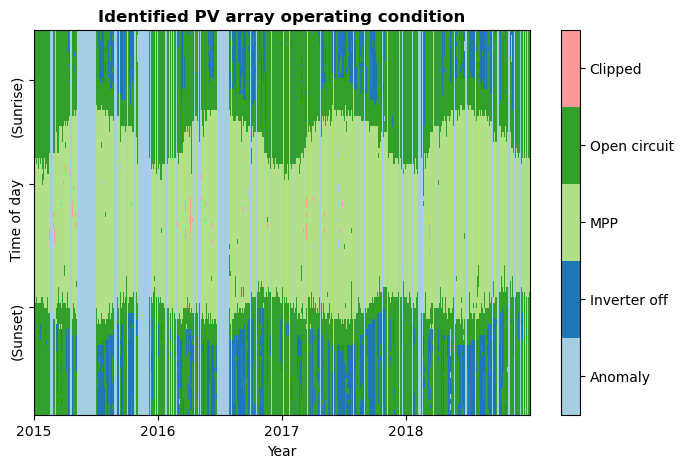

In [12]:
if method=='sdt':
    fig = pvproplot.plot_operating_cls(pre.dh.extra_matrices)

In [13]:
filter_IE = pre.find_current_irradiance_outliers(points_per_iteration=5000, epsilon=2)

In [14]:
max_k = len(filter_IE['upper_iter_idx'])
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
@interact
def show_inbounds_IE(k=(0,max_k,1)):

    k = round(k)
    cax = np.arange(filter_IE['lower_iter_idx'][k], filter_IE['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and(np.logical_not(filter_IE['outliers'][cax]), filter_IE['boolean_mask'][cax])
    outliers =  np.logical_and(filter_IE['outliers'][cax],filter_IE['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,1200,5)
    fig = plt.figure()
    plt.scatter(poa[cax][inbounds],current[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_IE['huber'][k].coef_ * x_smooth + filter_IE['huber'][k].intercept_,'g')

    plt.scatter(poa[cax][outliers], current[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('POA (W/m^2)')
    plt.ylabel('Current (A)')
    plt.xlim([0,1200])
    plt.ylim([0,11])
    plt.legend()
    plt.show()



interactive(children=(IntSlider(value=9, description='k', max=19), Output()), _dom_classes=('widget-interact',…

In [15]:
filter_TV= pre.find_temperature_voltage_outliers(voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=5000,
                                                 epsilon=2)

In [16]:
max_k = len(filter_TV['upper_iter_idx'])
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
voltage = pre.df[pre.voltage_dc_key]/pre.modules_per_string
temperature_cell = pre.df['temperature_cell']
@interact
def show_inbounds_TV(k=(0,max_k,1)):
    k = round(k)
    cax = np.arange(filter_TV['lower_iter_idx'][k], filter_TV['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and.reduce((
        np.logical_not(filter_TV['outliers'][cax]),
        filter_TV['boolean_mask'][cax]
    ))
    outliers =  np.logical_and(filter_TV['outliers'][cax],        filter_TV['boolean_mask'][cax])

    x_smooth = np.linspace(0,70,2)
    fig = plt.figure()
    plt.scatter(temperature_cell[cax][inbounds],voltage[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_TV['huber'][k].coef_ * x_smooth + filter_TV['huber'][k].intercept_,'g')
    # print(filter_TV['huber'][k].coef_)

    plt.scatter(temperature_cell[cax][outliers], voltage[cax][outliers], s=1,
                c='r',label='Outliers')
    plt.xlabel('Cell Temperature (C)')
    plt.ylabel('Voltage (V)')
    plt.xlim([-20,70])
    plt.ylim([0,70])
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=9, description='k', max=19), Output()), _dom_classes=('widget-interact',…

### Find clear time

In [17]:
filter_clear_time=True
if filter_clear_time:
    pre.find_clear_times_sdt()

No SCSF model detected. Fitting now...
----------------------
SCSF Problem Setup
----------------------
Matrix Size: 72 x 1461 = 105192 power measurements
Sparsity: 86.20%
14512 non-zero measurements under clear conditions
Model size: 72 x 6 + 6 x 1461 = 9198 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 7.646e+07, f1: 1.360e+05, f2: 8.113e+02, f3: 5.407e+07, f4: 2.226e+07
    Minimizing left matrix


/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 6.022e+04, f1: 5.414e+04, f2: 7.603e+02, f3: 5.324e+03, f4: 2.813e-09
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 5.530e+04, f1: 5.083e+04, f2: 4.252e+02, f3: 4.044e+03, f4: 1.781e-08
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 5.426e+04, f1: 5.008e+04, f2: 5.001e+02, f3: 3.678e+03, f4: 1.278e-08
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 5.403e+04, f1: 4.991e+04, f2: 5.272e+02, f3: 3.595e+03, f4: 4.613e-08
    Minimizing left matrix
    Minimizing right matrix
5 - Objective: 5.394e+04, f1: 4.985e+04, f2: 5.367e+02, f3: 3.560e+03, f4: 3.131e-08
    Minimizing left matrix
    Minimizing right matrix
6 - Objective: 5.388e+04, f1: 4.979e+04, f2: 5.433e+02, f3: 3.544e+03, f4: 3.521e-08
    Minimizing left matrix
    Minimizing right matrix
7 - Objective: 5.383e+04, f1: 4.975e+04, f2: 5.507e+02, f3: 3.528e+03, f4: 2.579e-08
Minimization complete in 0.37 minutes


In [18]:
power = pre.df['power_dc']
@interact
def inspect_clear_time(plot_start=(0,len(power),100)):
    plt.figure(figsize=(11,3))
    N = 300
    cax = np.arange(plot_start,plot_start+N).astype('int')
    
    plt.plot(pre.df.index[cax], power[plot_start:plot_start+N])
    # mask = pre.df['monotonic'][cax]
    # plt.plot(pre.df.index[cax][mask], power[cax][mask],'r.',label='Monotonic')
    if 'clear_time' in pre.df:
        mask = pre.df['clear_time'][cax]
        plt.plot(pre.df.index[cax][mask], power[cax][mask],
            'r.',label='Clear time SDT')
    plt.legend()
    plt.ylabel('Power per module (W)')
    plt.show()

interactive(children=(IntSlider(value=52500, description='plot_start', max=105167, step=100), Output()), _dom_…

In [19]:
pre.dh.filled_data_matrix[pre.dh.filled_data_matrix>700]=0

In [20]:
iterative_fitting = IterativeFitting(pre.dh.filled_data_matrix)
run_scsf = False
if run_scsf:
    iterative_fitting.execute(bootstraps=5)

In [21]:
if run_scsf:
    clear_sky_signals = iterative_fitting.clear_sky_signals()
    degradation_rate = iterative_fitting.degradation_rate()
    print(degradation_rate)
    print(iterative_fitting.beta_value)
    beta = []
    for j in range(len(iterative_fitting.bootstrap_samples)):
        beta.append(iterative_fitting.bootstrap_samples[j]['beta'])
        
    print(beta)
    print('{:.1%} pm {:.1%}'.format(np.mean(beta), np.std(beta)))


In [22]:
pre.find_monotonic_times()

In [23]:
N = 5000
@interact
def inspect_kept_points(start_point=(0,len(pre.df),N),
                        current_irradiance_filter=True,
                        monotonic_filter=True,
                        clipping_filter=False,
                       clear_time_filter=False,
                        voltage_temperature_filter=True,
                        
                       ):

    cax = np.arange(start_point, start_point+N).astype('int')
    
    mask = np.array(pre.df['operating_cls'][cax]==0)
    
    voltage = pre.df[pre.voltage_dc_key][cax]/pre.modules_per_string
    current = pre.df[pre.current_dc_key][cax]/pre.parallel_strings
    poa = pre.df[pre.irradiance_poa_key][cax]
    temperature_cell = pre.df['temperature_cell'][cax]
    operating_cls = pre.df['operating_cls'][cax]/pre.parallel_strings
    
    if current_irradiance_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['current_irradiance_outliers'][cax]) )
    if clipping_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['clipped_times'][cax]))
    if monotonic_filter:
        mask = np.logical_and(mask, pre.df['monotonic'][cax])
    if clear_time_filter and 'clear_time' in pre.df:
        mask = np.logical_and(mask, np.array(pre.df['clear_time'][cax]))
    if voltage_temperature_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['voltage_temperature_outliers'][cax]))
        
    
    fig = plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    pvproplot.plot_Vmp_Imp_scatter_preprocess(voltage=voltage,
                         current=current,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_vmp_max=45,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    pvproplot.plot_poa_Imp_scatter(current=current,
                         poa=poa,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_imp_max=10)
    plt.show()

interactive(children=(IntSlider(value=50000, description='start_point', max=105167, step=5000), Checkbox(value…

## Perform PVPRO analysis

In [24]:
pvp = PvProHandler(df=pre.df,
                  voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   system_name=sys_name,
                   technology=technology
                  )

In [25]:
boolean_mask = np.logical_or.reduce((np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>200
                                        )),
                                     pvp.df['operating_cls']==1,
                                     pvp.df['operating_cls']==2
                                    ))


In [26]:
pvp.estimate_p0(boolean_mask=np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>500,
                                        )),
                                    technology = technology
                                    )
print(pd.Series(pvp.p0))

diode_factor               9.950710e-01
photocurrent_ref           8.793407e+00
saturation_current_ref     4.637813e-10
resistance_series_ref      3.267298e-01
resistance_shunt_ref       6.000000e+02
conductance_shunt_extra    0.000000e+00
v_oc_ref                   3.630789e+01
i_mp_ref                   8.200470e+00
i_sc_ref                   8.751366e+00
v_mp_ref                   2.949783e+01
p_mp_ref                   2.418961e+02
alpha_isc                  4.395295e-03
alpha_imp                 -6.395574e-03
beta_vmp                  -1.332882e-01
beta_voc                  -1.301993e-01
cells_in_series            6.000000e+01
nNsVth_ref                 1.534516e+00
dtype: float64


### Off MPP analysis

In [27]:
boolean_mask_test=np.logical_and.reduce((np.logical_not(pvp.df['clipped_times']),
                                        pvp.df[pvp.irradiance_poa_key]>10,
                                        ))

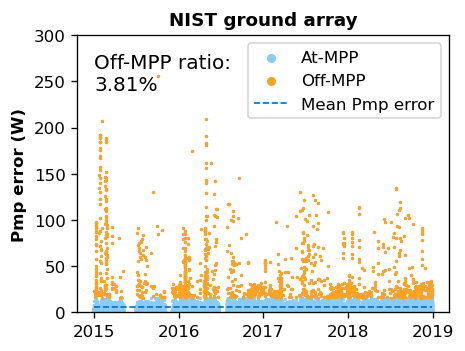

In [28]:
pvproplot.plot_Pmp_error_vs_time(pvp, boolean_mask_test, sys_name = 'NIST ground array')

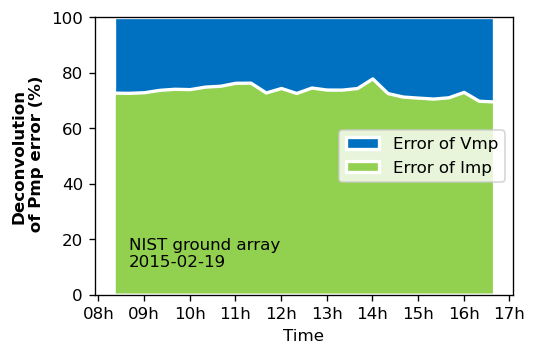

In [29]:
# Example of the deconvolution of the Pmp error on 2015-02-19
pvp.deconvolve_Pmp_error_on_V_I(boolean_mask_test, range(1350,1400), sys_name = 'NIST ground array')

### Inspect the startpoint

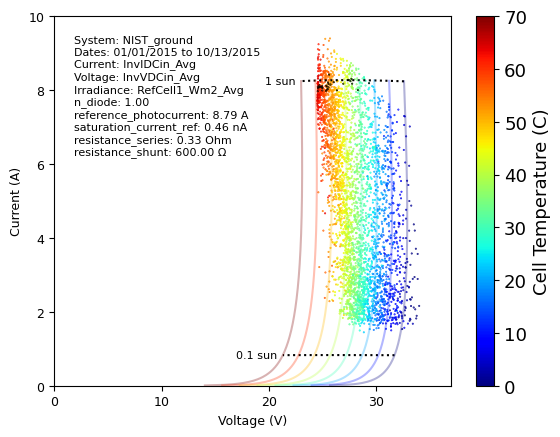

In [30]:
pvproplot.plot_Vmp_Imp_scatter(pvp,
        df=pvp.df[boolean_mask][:10000],
        p_plot=pvp.p0,
        plot_imp_max=10,
        plot_vmp_max=37)

In [31]:
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'days_per_run': 14,
    'iterations_per_year': 26,
    'start_point_method': 'last',
    'saturation_current_multistart': [1],
    'verbose': False,
    'diode_factor': pvp.p0['diode_factor']
}

### Execute parameter extraction

In [32]:
fit_params = ['photocurrent_ref', 'saturation_current_ref',
                          'resistance_series_ref', 
                         'conductance_shunt_extra',
                         'resistance_shunt_ref', 
                          'diode_factor']
lower_bounds = dict(
            diode_factor=0.1,
            photocurrent_ref=0.01,
            saturation_current_ref=5e-12,
            resistance_series_ref=0.1,
            conductance_shunt_extra=0,
            resistance_shunt_ref=100
        )

upper_bounds = dict(
    diode_factor=1.5,
    photocurrent_ref=10,
    saturation_current_ref=1e-6,
    resistance_series_ref=2,
    conductance_shunt_extra=0,
    resistance_shunt_ref=1000
)
ret = pvp.execute(iteration='all', fit_params= fit_params,
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                  **hyperparams,
                  boolean_mask = boolean_mask,
                  technology=technology) 

 22%|██▏       | 23/103 [00:00<00:02, 29.58it/s]/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/pvlib/tools.py:358: RuntimeWarning: All-NaN axis encountered
  iterlimit = 1 + np.nanmax(
 38%|███▊      | 39/103 [00:01<00:02, 23.06it/s]/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/pvlib/tools.py:358: RuntimeWarning: All-NaN axis encountered
  iterlimit = 1 + np.nanmax(
100%|██████████| 103/103 [00:04<00:00, 23.41it/s]

Elapsed time: 0.07 min


### Pull out results and inspect goodness of fit

In [48]:
pfit = pvp.result['p']

In [49]:
@interact
def inspect_results(k=(0,len(pfit),1),filter=True):

    cax = np.logical_and(
        pvp.df.index>pfit['t_start'][k],
        pvp.df.index<pfit['t_end'][k]
    )
    if filter:
        mask = boolean_mask[cax]
    else:
        mask = np.ones_like(boolean_mask[cax])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvproplot.plot_Vmp_Imp_scatter(pvp, df=pvp.df[cax][mask],
                                p_plot=pfit.iloc[k],
                            plot_vmp_max=37,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    pvproplot.plot_current_irradiance_mpp_scatter(pvp, df=pvp.df[cax][mask],
                                        p_plot=pfit.iloc[k], plot_imp_max=10)
    plt.gcf().set_dpi(100)
    plt.show()

interactive(children=(IntSlider(value=51, description='k', max=103), Checkbox(value=True, description='filter'…

### Plot evolution of extracted parameters

In [50]:
# Calculate YOY trend
yoy_result = pvp.analyze_yoy(pfit)

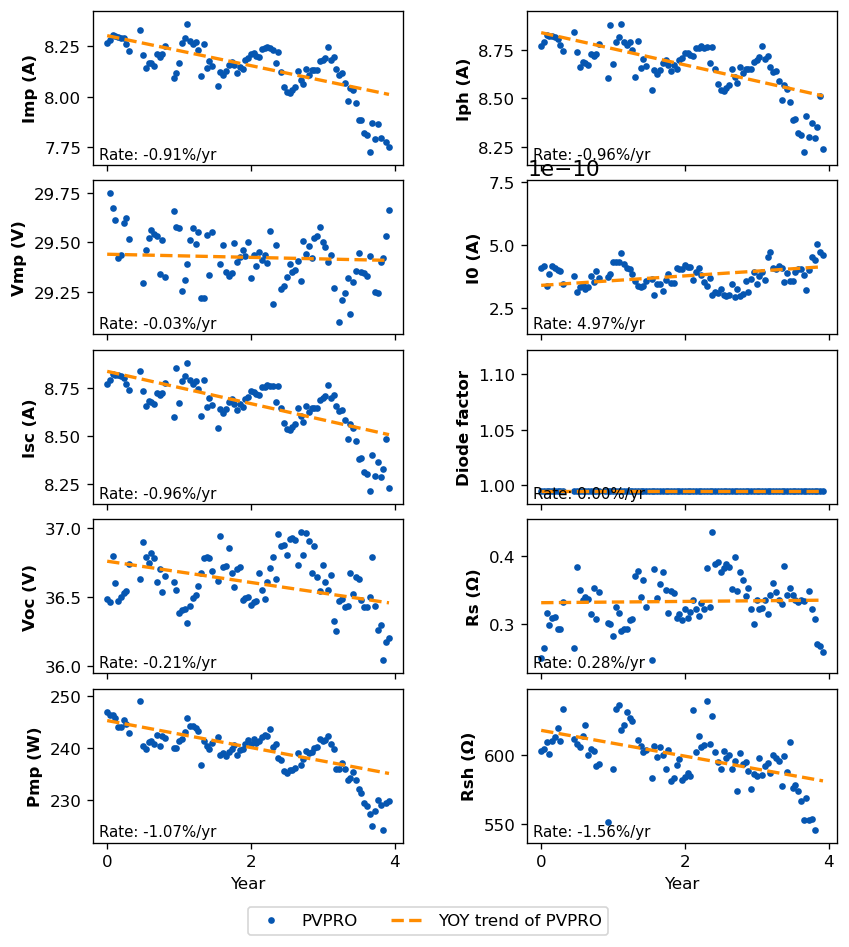

In [51]:
keys_to_plot = ['i_mp_ref', 'photocurrent_ref',
                        'v_mp_ref', 'saturation_current_ref',
                        'i_sc_ref', 'diode_factor',
                        'v_oc_ref', 'resistance_series_ref',
                        'p_mp_ref', 'resistance_shunt_ref'
                        ]
                        
for key in keys_to_plot:
    para = pfit[key]
    inx = (para <np.mean(para)-3*np.std(para)) | (para >np.mean(para)+3*np.std(para))
    pfit[key][inx] = np.nan

pvproplot.plot_results_timeseries_error(pfit,yoy_result = yoy_result, yoy_plot = True,
                        keys_to_plot=keys_to_plot, legendloc  = [0.5, -0.6])
plt.gcf().set_dpi(120)